# Laboratorio 8 - Gymnasium y DQN
- Ricardo Méndez
- Sara Echverría
- Melissa Pérez Alarcón, 21385

https://github.com/MelissaPerez09/Lab08-CC3104

In [41]:
import random
import collections
import math
from typing import Deque


import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [42]:
ENV_NAME = 'CartPole-v1'
SEED = 42
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 1000
TARGET_UPDATE_FREQ = 1000 # steps
MAX_EPISODES = 800
MAX_STEPS_PER_EPISODE = 500
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 50000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [44]:
Transition = collections.namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer: Deque[Transition] = collections.deque(maxlen=capacity)


    def push(self, *args):
        self.buffer.append(Transition(*args))


    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states = torch.tensor(np.array([t.state for t in batch]), dtype=torch.float32, device=DEVICE)
        actions = torch.tensor([t.action for t in batch], dtype=torch.int64, device=DEVICE).unsqueeze(1)
        rewards = torch.tensor([t.reward for t in batch], dtype=torch.float32, device=DEVICE).unsqueeze(1)
        next_states = torch.tensor(np.array([t.next_state for t in batch]), dtype=torch.float32, device=DEVICE)
        dones = torch.tensor([t.done for t in batch], dtype=torch.float32, device=DEVICE).unsqueeze(1)
        return states, actions, rewards, next_states, dones


    def __len__(self):
        return len(self.buffer)

In [45]:
class QNetwork(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, hidden_dim: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [46]:
class DQNAgent:
    def __init__(self, obs_dim, action_dim):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.online_net = QNetwork(obs_dim, action_dim).to(DEVICE)
        self.target_net = QNetwork(obs_dim, action_dim).to(DEVICE)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=LR)
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        self.total_steps = 0

    def select_action(self, state, epsilon=0.1):
        # state: np.array
        if random.random() < epsilon:
            return random.randrange(self.action_dim)
        else:
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            with torch.no_grad():
                qvals = self.online_net(s)
            return int(torch.argmax(qvals, dim=1).item())

    def update(self):
        if len(self.replay_buffer) < BATCH_SIZE:
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)

        # Q(s,a) for chosen actions
        q_values = self.online_net(states).gather(1, actions)

        # Target: r + gamma * max_a' Q_target(s', a') * (1 - done)
        with torch.no_grad():
            next_q_values = self.target_net(next_states)
            max_next_q_values, _ = torch.max(next_q_values, dim=1, keepdim=True)
            target_q = rewards + GAMMA * (1 - dones) * max_next_q_values

        loss = nn.functional.mse_loss(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def soft_update_target(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def save(self, path):
        torch.save(self.online_net.state_dict(), path)

    def load(self, path):
        self.online_net.load_state_dict(torch.load(path, map_location=DEVICE))
        self.target_net.load_state_dict(self.online_net.state_dict())


In [47]:
def train():
    env = gym.make(ENV_NAME)
    env.action_space.seed(SEED) 

    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(obs_dim, action_dim)

    state, _ = env.reset(seed=SEED)
    for _ in range(MIN_REPLAY_SIZE):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        if done:
            state, _ = env.reset()

    episode_rewards = []
    losses = []
    epsilon_by_step = lambda step: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * step / EPS_DECAY)

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        total_reward = 0
        for step in range(MAX_STEPS_PER_EPISODE):
            epsilon = epsilon_by_step(agent.total_steps)
            action = agent.select_action(state, epsilon)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.total_steps += 1

            loss = agent.update()
            if loss is not None:
                losses.append(loss)

            if agent.total_steps % TARGET_UPDATE_FREQ == 0:
                agent.soft_update_target()

            if done:
                break

        episode_rewards.append(total_reward)
        print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

        if np.mean(episode_rewards[-100:]) >= 475.0:
            print("Environment solved!")
            break

    env.close()
    return agent, episode_rewards, losses


In [48]:
agent, rewards, losses = train()

Episode 1, Reward: 19.0, Epsilon: 1.000
Episode 2, Reward: 17.0, Epsilon: 0.999
Episode 3, Reward: 32.0, Epsilon: 0.999
Episode 4, Reward: 19.0, Epsilon: 0.998
Episode 5, Reward: 16.0, Epsilon: 0.998
Episode 6, Reward: 29.0, Epsilon: 0.997
Episode 7, Reward: 21.0, Epsilon: 0.997
Episode 8, Reward: 62.0, Epsilon: 0.996
Episode 9, Reward: 12.0, Epsilon: 0.996
Episode 10, Reward: 54.0, Epsilon: 0.994
Episode 11, Reward: 20.0, Epsilon: 0.994
Episode 12, Reward: 13.0, Epsilon: 0.994
Episode 13, Reward: 16.0, Epsilon: 0.994
Episode 14, Reward: 14.0, Epsilon: 0.993
Episode 15, Reward: 24.0, Epsilon: 0.993
Episode 16, Reward: 11.0, Epsilon: 0.993
Episode 17, Reward: 16.0, Epsilon: 0.992
Episode 18, Reward: 11.0, Epsilon: 0.992
Episode 19, Reward: 12.0, Epsilon: 0.992
Episode 20, Reward: 19.0, Epsilon: 0.991
Episode 21, Reward: 12.0, Epsilon: 0.991
Episode 22, Reward: 16.0, Epsilon: 0.991
Episode 23, Reward: 53.0, Epsilon: 0.990
Episode 24, Reward: 51.0, Epsilon: 0.989
Episode 25, Reward: 17.0,

In [49]:
def plot_results(episode_rewards, losses):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode Rewards over Time')

    plt.subplot(1,2,2)
    plt.plot(losses)
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    plt.title('Loss over Time')

    plt.tight_layout()
    plt.show()

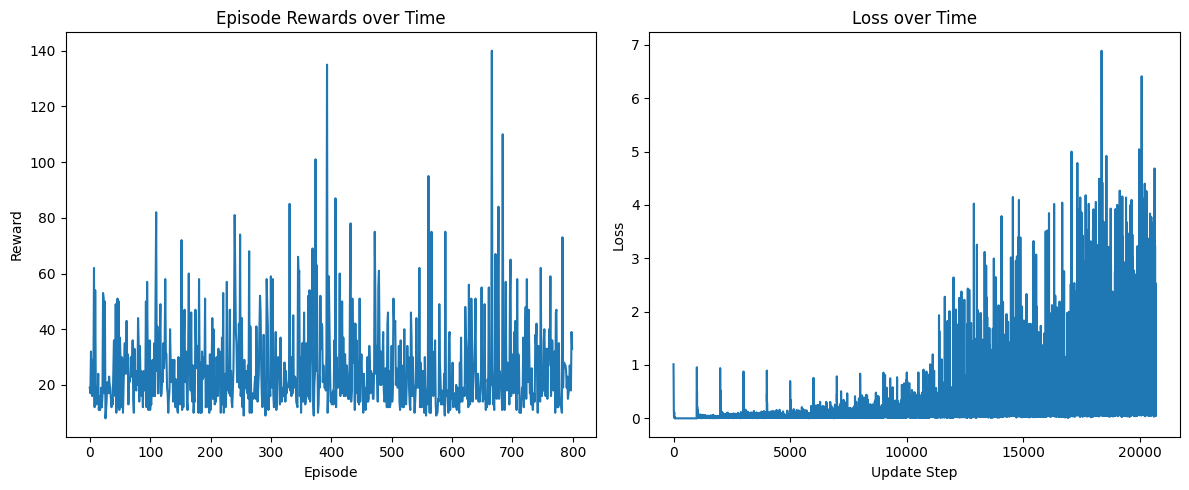

In [50]:
plot_results(rewards, losses)

In [51]:
def evaluate_agent(agent, num_episodes=5):
    env = gym.make(ENV_NAME, render_mode="human") 
    env.reset(seed=SEED + 100)

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            env.render() 
            action = agent.select_action(state, epsilon=0.0)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    env.close()


In [52]:
evaluate_agent(agent, num_episodes=5)